In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tensorflow import keras 
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'python-packages/'))
from deep_hashing_models import *
from similarities import *
from lsh_search import *

# 1. Data Preparation

In [3]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/')

In [4]:
df_distinct_stacks = pd.read_csv(data_repo + 'frequent_stack_traces.csv', index_col = [0])
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])

In [5]:
n_stacks = df_distinct_stacks.shape[0]
n_stacks

1000

In [6]:
vectorizer_bag_of_frames = CountVectorizer(token_pattern = r"(?u)\b[a-zA-Z0-9_.]{2,}\b")
s = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\n',' '))
s = s.apply(lambda x : x.replace('$',''))
s = s.apply(lambda x : x.replace('/',''))
s = s.apply(lambda x : x.replace('<',''))
s = s.apply(lambda x : x.replace('>',''))
X_bag_of_frames = vectorizer_bag_of_frames.fit_transform(list(s)).toarray()
df_bag_of_frames = pd.DataFrame(data = X_bag_of_frames, columns = vectorizer_bag_of_frames.get_feature_names())

In [7]:
X_train, X_validation, Y_train, Y_validation = train_test_split(df_measures.index, df_measures['PDM'], test_size = 0.2) 

In [8]:
indexes_train_1 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_train_2 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()
indexes_validation_1 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_validation_2 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()

In [9]:
X_train = dict()
X_train['stack_1'] = df_bag_of_frames.loc[indexes_train_1].values
X_train['stack_2'] = df_bag_of_frames.loc[indexes_train_2].values

X_validation = dict()
X_validation['stack_1'] = df_bag_of_frames.loc[indexes_validation_1].values
X_validation['stack_2'] = df_bag_of_frames.loc[indexes_validation_2].values

In [10]:
Y_train = Y_train.values
Y_validation = Y_validation.values

In [11]:
assert X_train['stack_1'].shape == X_train['stack_2'].shape
assert len(X_train['stack_1']) == len(Y_train)

### Distribution of training data

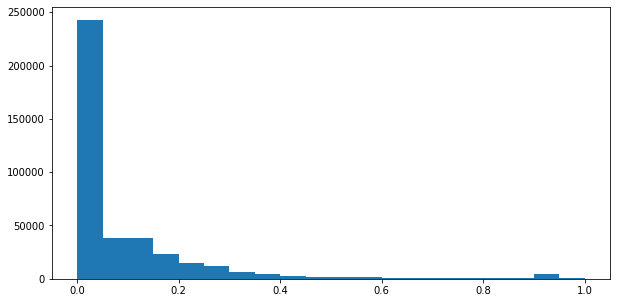

In [12]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_train, 20, alpha = 1, density = False)
plt.show()

### Distribution of test data

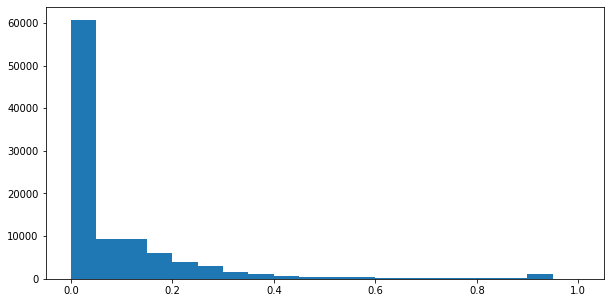

In [13]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_validation, 20, alpha = 1, density = False)
plt.show()

# 2. Model Design

In [14]:
'Number of hash tables functions' 
m = 64

In [15]:
'Number of bits per hash function' 
b = 8

In [16]:
'Size hash vector'
size_hash_vector = m * b
size_hash_vector

512

## 2.1. Feature learning phase

In [17]:
x = Sequential()
x.add(Dense(2048, input_dim = X_train['stack_1'].shape[1], activation = 'tanh'))
x.add(Dense(1024, activation = 'tanh'))
x.add(Dense(size_hash_vector, activation = 'tanh'))
shared_model = x

## 2.2. Siamese Model 

In [18]:
input_shape = (X_train['stack_1'].shape[1],)
model = siamese_model(shared_model, input_shape, b, m, is_sparse = True, print_summary = False)

## 2.3. Model training 

In [19]:
siamese_model = train_siamese_model(model, X_train, X_validation, Y_train, Y_validation, batch_size = 512, epochs = 20)

Epoch 1/20
781/781 [==============================] - 38s 37ms/step - loss: 0.0044 - ham_dist_loss: 0.0044 - prod_vec_loss: 0.0112 - prod_vec_1_loss: 0.0110 - sum_vec_loss: 2.3498e-04 - sum_vec_1_loss: 2.3145e-04 - ham_dist_rmse: 0.0660 - ham_dist_mae: 0.0244 - val_loss: 7.7374e-04 - val_ham_dist_loss: 7.3454e-04 - val_prod_vec_loss: 0.0026 - val_prod_vec_1_loss: 0.0026 - val_sum_vec_loss: 1.2829e-04 - val_sum_vec_1_loss: 1.3391e-04 - val_ham_dist_rmse: 0.0271 - val_ham_dist_mae: 0.0131
Epoch 2/20
781/781 [==============================] - 26s 34ms/step - loss: 5.9661e-04 - ham_dist_loss: 5.6921e-04 - prod_vec_loss: 0.0019 - prod_vec_1_loss: 0.0019 - sum_vec_loss: 1.1839e-04 - sum_vec_1_loss: 1.1738e-04 - ham_dist_rmse: 0.0239 - ham_dist_mae: 0.0114 - val_loss: 5.1563e-04 - val_ham_dist_loss: 4.9716e-04 - val_prod_vec_loss: 0.0015 - val_prod_vec_1_loss: 0.0015 - val_sum_vec_loss: 1.1274e-04 - val_sum_vec_1_loss: 1.1015e-04 - val_ham_dist_rmse: 0.0223 - val_ham_dist_mae: 0.0103
Epoch 3/

# 3. Model Evaluation

In [20]:
model.layers

## 3.1. Loss functions

#### 3.1.1. MSE of $\mathcal{L}_{DeepLSH}$

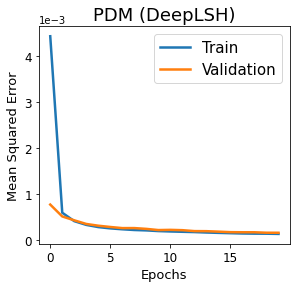

In [21]:
plt.rcParams["figure.figsize"] = (4.5,4)
plt.plot(siamese_model.history['loss'], linewidth = 2.5)
plt.plot(siamese_model.history['val_loss'], linewidth = 2.5)
plt.title('PDM (DeepLSH)', fontsize = 18)
plt.ylabel('Mean Squared Error', fontsize = 13)
plt.xlabel('Epochs', fontsize = 13)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.ticklabel_format(axis = 'y', style='', scilimits=(0,0))
plt.savefig('Results/DeepLSH/loss-MSE.png', bbox_inches='tight')
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.2. RMSE of LSH preserving loss

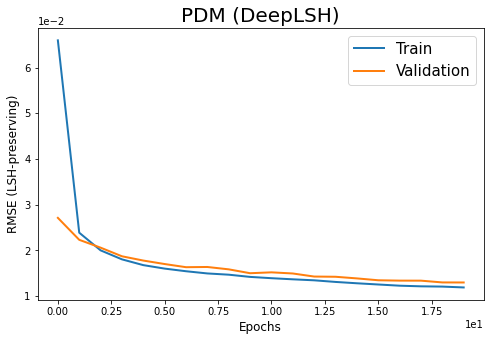

In [22]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_rmse'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_rmse'], linewidth = 2)
plt.title('PDM (DeepLSH)', fontsize = 20)
plt.ylabel('RMSE (LSH-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.3. MAE of LSH preserving loss

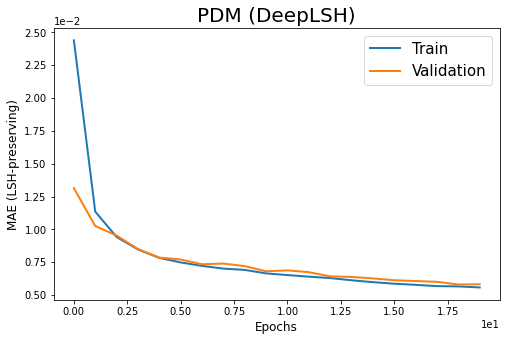

In [23]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_mae'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_mae'], linewidth = 2)
plt.title('PDM (DeepLSH)', fontsize = 20)
plt.ylabel('MAE (LSH-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

## 3.2. Model Predictions

In [24]:
predictions = predict(model, X_validation)

### 3.2.1. Examples

In [25]:
np.around(predictions[0][:50],3) 

array([0.   , 0.187, 0.124, 0.001, 0.016, 0.187, 0.   , 0.219, 0.074,
       0.   , 0.   , 0.25 , 0.   , 0.094, 0.016, 0.906, 0.08 , 0.096,
       0.172, 0.   , 0.125, 0.   , 0.   , 0.   , 0.   , 0.125, 0.031,
       0.031, 0.078, 0.   , 0.   , 0.266, 0.109, 0.   , 0.   , 0.   ,
       0.111, 0.171, 0.   , 0.171, 0.   , 0.   , 0.063, 0.312, 0.156,
       0.   , 0.   , 0.   , 0.   , 0.031], dtype=float32)

In [26]:
np.around(Y_validation[:50],3) 

array([0.   , 0.167, 0.119, 0.   , 0.025, 0.149, 0.   , 0.216, 0.067,
       0.   , 0.   , 0.248, 0.   , 0.098, 0.01 , 0.913, 0.07 , 0.115,
       0.175, 0.   , 0.142, 0.   , 0.   , 0.   , 0.   , 0.119, 0.025,
       0.041, 0.072, 0.   , 0.   , 0.264, 0.106, 0.   , 0.   , 0.   ,
       0.125, 0.183, 0.   , 0.161, 0.   , 0.   , 0.054, 0.31 , 0.136,
       0.   , 0.   , 0.   , 0.   , 0.   ])

### 3.2.2. Spearman $\rho$ and Kendall $\tau$ correlation

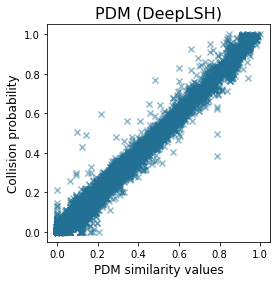

In [27]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(Y_validation, predictions[0], alpha = 0.5, marker = 'x', c = '#227093')
plt.title('PDM (DeepLSH)', fontsize = 16)
plt.xlabel("PDM similarity values", fontsize = 12)
plt.ylabel("Collision probability", fontsize = 12)
plt.savefig('Results/DeepLSH/PDM-correlation.png', bbox_inches='tight')
plt.show()

In [28]:
rho, p_value = spearman_rho(predictions, Y_validation)
rho

0.9208965642772211

In [29]:
tau, p_value = kendall_tau(predictions, Y_validation)
tau

0.8500901338505086

## 3.3. Approximate Hamming Evaluation

In [30]:
output_layer = 2
model.layers[output_layer]

In [31]:
intermediate_model = intermediate_model_trained(shared_model, output_layer)

In [32]:
intermediate_model.save('Models/model-deep-lsh.model')

INFO:tensorflow:Assets written to: Models/model-deep-lsh.model/assets


In [33]:
#intermediate_model = keras.models.load_model('Models/model-deep-lsh.model')

### 3.3.1. Example of a hash vector provided by the model (in the last epoch)

In [34]:
'First 64 bits'
intermediate_model.predict(df_bag_of_frames.iloc[[10]])[0][:64]

array([ 1.        , -1.        , -1.        ,  1.        , -0.9999814 ,
       -1.        ,  0.99998987,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        , -1.        ,  1.        , -1.        ,
        1.        , -1.        , -1.        , -1.        ,  1.        ,
        1.        , -0.9999408 , -1.        , -1.        ,  1.        ,
        1.        ,  1.        , -1.        ,  1.        , -1.        ,
        1.        , -0.9999625 , -1.        ,  1.        ,  1.        ,
       -1.        ,  1.        , -0.9997838 ,  1.        ,  1.        ,
       -1.        ,  1.        ,  1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        ,  1.        ,
       -1.        , -1.        ,  1.        , -1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        , -1.        ,
        1.        , -1.        ,  1.        , -0.9999977 ], dtype=float32)

### 3.3.2. Average value of the absolute hash values

In [35]:
hash_vectors = intermediate_model.predict(df_bag_of_frames)

In [36]:
hash_vectors

array([[-1.       , -1.       , -1.       , ..., -1.       ,  1.       ,
        -1.       ],
       [-1.       , -1.       , -1.       , ..., -1.       ,  1.       ,
        -1.       ],
       [ 1.       , -1.       , -1.       , ..., -1.       ,  1.       ,
        -1.       ],
       ...,
       [ 1.       ,  1.       , -1.       , ...,  1.       , -1.       ,
         1.       ],
       [ 1.       , -1.       , -1.       , ..., -1.       ,  1.       ,
         1.       ],
       [-1.       ,  1.       ,  0.9992112, ...,  1.       , -1.       ,
         1.       ]], dtype=float32)

In [37]:
np.mean(np.abs(hash_vectors))

0.9951342

### 3.3.3. Ratio of binary values from hash vectors provided by the model

In [38]:
hash_vectors[(hash_vectors == 1) | (hash_vectors == -1)].size / hash_vectors.size

0.82277734375

### 3.3.4. Comparison between approximate hamming and real hamming

In [39]:
df_hamming = compare_hamming(X_validation, intermediate_model, b, size_hash_vector)

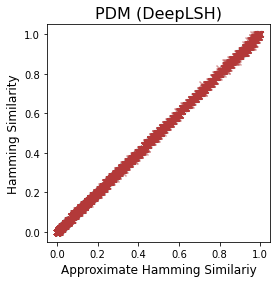

In [40]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(predictions[0], df_hamming['hamming'], alpha = 0.5, marker = 'x', c = '#b33939')
plt.xlabel("Approximate Hamming Similariy", fontsize = 12)
plt.ylabel("Hamming Similarity", fontsize = 12)
plt.title('PDM (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/PDM-hamming-comparison', bbox_inches='tight')
plt.show()

# 4. Locality Sensitive Hashing

In [41]:
hash_vectors_hamming = convert_to_hamming(hash_vectors)

In [42]:
params = lsh_hyperparams(m)
'(K,L)'
params 

[(1, 64), (2, 32), (4, 16), (8, 8), (16, 4), (32, 2), (64, 1)]

## 4.1. Choose the best combination (L, K)

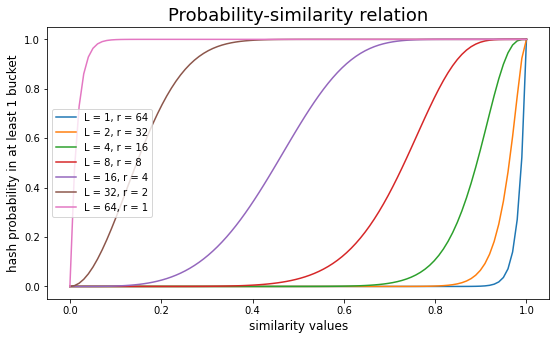

In [43]:
plt.rcParams["figure.figsize"] = [9, 5]
x = np.linspace(0, 1, 100)
for param in params:
    y = 1 - (1 - (x)**param[1])**param[0]
    plt.plot(x, y, label = 'L = %d, r = %d' %param)
plt.xlabel("similarity values", fontsize = 12)
plt.ylabel("hash probability in at least 1 bucket", fontsize = 12)
plt.title('Probability-similarity relation', fontsize = 18)
plt.legend()

In [44]:
df_probLSH = mean_prob_hashing_smallest_elt(n_stacks, params, hash_vectors_hamming, b, df_measures, 'PDM', trace = False)

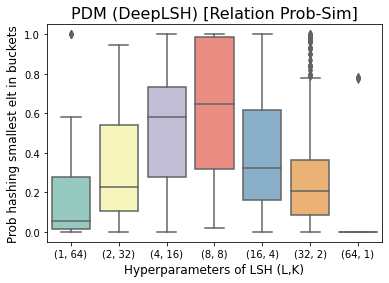

In [45]:
f, ax = plt.subplots(figsize=(6, 4))
ax = sns.boxplot(data = df_probLSH, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Prob hashing smallest elt in buckets", fontsize = 12)
plt.title('PDM (DeepLSH) [Relation Prob-Sim]', fontsize = 16)
plt.savefig('Results/DeepLSH/PDM-Relation-Prob-Sim', bbox_inches='tight')
plt.show()

In [46]:
'L = K = 8'
L, K = params[3]
L, K

(8, 8)

### 4.1.1. Mean and Median probability for all stack traces for a the best combination of $K$ and $L$

In [47]:
df_probLSH.mean()['(8, 8)']

0.6195524390932932

In [48]:
df_probLSH.median()['(8, 8)']

0.6461246665498239

## 4.2. Build hash tables with binary hash vectors w.r.t $K$ and $L$

In [49]:
hash_tables = create_hash_tables(L, K, b, hash_vectors_hamming)

In [50]:
with open('Hash-Tables/hash_tables_deeplsh.pkl', 'wb') as f:
    pickle.dump(hash_tables, f)

## 4.3. Search for approximate nearest neighbors (this procedure need to be explained in the paper) 

In [51]:
'pointer to the stack trace'
index = random.randint(0,n_stacks)
index

929

In [52]:
set_near_duplicates = near_duplicates(L, K, b, index, hash_vectors_hamming, hash_tables)
set_near_duplicates

{214, 285, 369, 404, 465, 490, 573, 635, 705, 929}

In [53]:
list_near_duplicate_pairs = near_duplicate_pairs(index, set_near_duplicates, n_stacks)
n_duplicate_pairs = len(list_near_duplicate_pairs)

In [54]:
near_duplicates_sim = df_measures['PDM'][list_near_duplicate_pairs].sort_values(ascending = False)
near_duplicates_sim

370143    0.940514
357118    0.940514
433363    0.940514
301294    0.940514
244888    0.940514
456358    0.939113
408904    0.854711
191709    0.847499
322714    0.733305
Name: PDM, dtype: float64

In [55]:
set_real_nns, real_nns_sim = real_nns(index, df_measures, 'PDM', n_stacks, n_duplicate_pairs)
set_real_nns

{214, 285, 369, 465, 490, 573, 635, 705, 790}

In [56]:
real_nns_sim[:n_duplicate_pairs]

433363    0.940514
357118    0.940514
370143    0.940514
244888    0.940514
301294    0.940514
456358    0.939113
408904    0.854711
191709    0.847499
477693    0.820531
dtype: float64

## 4.4. Metrics

### 4.4.1. Ratio of finding the $k$ real nearest neighbor with the Least $L$ (Recal rate at $k$ first positions)

In [57]:
'All params'
k_first_positions = 1
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'PDM')

0.844

In [58]:
'Best param'
k_first_positions = 1
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'PDM')

0.9706227967097533

-----------------------------------------------------------------

In [59]:
'All params'
k_first_positions = 3
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'PDM')

0.8803333333333319

In [60]:
'Best param'
k_first_positions = 3
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'PDM')

0.9575936883629188

-----------------------------------------------------------------

In [61]:
'All params'
k_first_positions = 5
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'PDM')

0.9013999999999993

In [62]:
'Best param'
k_first_positions = 5
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'PDM')

0.9591549295774657

### 4.4.2. Generalized MRR

$ \frac{1}{|\mathcal{R}_i|} \sum_{s' \in \mathcal{R}_i} \frac{\text{rank}(s',\mathcal{R}_i)}{\text{rank}(s',NNs(s_i))}$

In [63]:
generalized_mrr(near_duplicates_sim, real_nns_sim)

0.9473684210526316

In [64]:
df_knns = mean_generalized_mrr(n_stacks, params, hash_vectors_hamming, b, df_measures ,'PDM', trace = False)
df_knns.mean(skipna = True, axis = 0)

(1, 64)    0.933209
(2, 32)    0.955316
(4, 16)    0.945024
(8, 8)     0.949710
(16, 4)    0.927965
(32, 2)    0.915085
(64, 1)    0.997925
dtype: float64

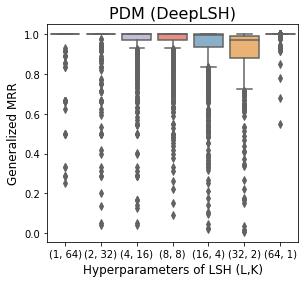

In [65]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_knns, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Generalized MRR", fontsize = 12)
plt.title('PDM (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/Generalized-MRR', bbox_inches='tight')
plt.show()

### 4.4.3. Recall w.r.t. LSH

In [66]:
df_recall = recall_all(n_stacks, params, hash_vectors_hamming, b, df_measures ,'PDM', trace = False)
df_recall.mean(skipna = True)

(1, 64)    0.925926
(2, 32)    0.822040
(4, 16)    0.868199
(8, 8)     0.875447
(16, 4)    0.863524
(32, 2)    0.783236
(64, 1)    0.984927
dtype: float64

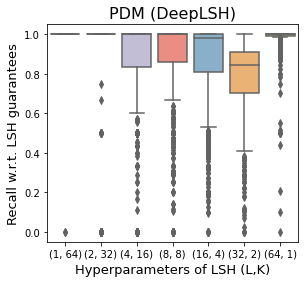

In [67]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_recall, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("Recall w.r.t. LSH guarantees", fontsize = 13)
plt.title('PDM (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/Recall-LSH', bbox_inches='tight')
plt.show()

### 4.4.4. Precison w.r.t. LSH

In [68]:
df_precision = precision_all(n_stacks, params, hash_vectors_hamming, b, df_measures ,'PDM', trace = False)
df_precision.mean(skipna = True, axis = 0)

(1, 64)    0.096220
(2, 32)    0.307143
(4, 16)    0.750159
(8, 8)     0.838518
(16, 4)    0.845510
(32, 2)    0.837909
(64, 1)    0.921058
dtype: float64

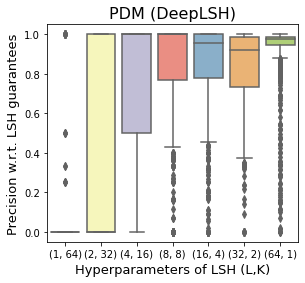

In [69]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_precision, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("Precision w.r.t. LSH guarantees", fontsize = 13)
plt.title('PDM (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/precision-LSH', bbox_inches='tight')
plt.show()

### 4.4.5. Fscore w.r.t. LSH

In [70]:
df_score_all = fscore_all(df_precision, df_recall)
df_score_all.mean(skipna = True)

(1, 64)    0.103401
(2, 32)    0.307547
(4, 16)    0.726344
(8, 8)     0.811011
(16, 4)    0.825461
(32, 2)    0.786825
(64, 1)    0.942723
dtype: float64

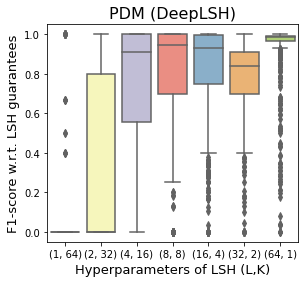

In [71]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_score_all, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("F1-score w.r.t. LSH guarantees", fontsize = 13)
plt.title('PDM (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/fscore-LSH', bbox_inches='tight')
plt.show()